In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sksurv.compare import compare_survival

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import concordance_index_ipcw
from sksurv.metrics import brier_score

from lifelines.statistics import logrank_test

In [2]:
# file_path = './survival_results'
train_df_control = pd.read_csv('/Users/yuzimeng/Desktop/CBB/Yale/Lajos_Lab/W2_DFA&SA_on_clinic_data/placebo_both_clinic_gene_data_for_training_after_merged.csv', index_col=0)
gene_exp = train_df_control.iloc[:, :-10] #gene exp
y = train_df_control.iloc[:, -10:] #survival time and event

print(gene_exp.shape, y.shape)

clinical_val = train_df_control[['Menospausal Status', 'Age', 'Risk Group']]
survival_val = train_df_control[['USI','Time to event if any (days)','IDFS Event']]
print(clinical_val.shape, survival_val.shape)
print(y.columns)

(150, 19447) (150, 10)
(150, 3) (150, 3)
Index(['USI', 'RNA Batch', 'Treatment Arm', 'Menospausal Status', 'Age',
       'Allocation', 'Risk Group', 'IDFS Event', 'Duration of followup (days)',
       'Time to event if any (days)'],
      dtype='object')


In [85]:
n = 40

In [86]:
gene_names = pd.read_excel(f'./by_HR_FDR_P/Multicox_results_top_{n}_filtered_by_HR_P.xlsx')
gene_names = gene_names['gene_name'].tolist()
print(gene_names)

selected_genes = gene_exp[gene_names]
print(selected_genes.shape)

for_scale = pd.concat([selected_genes,clinical_val['Age']],axis=1)
print(for_scale.shape)

['IFITM2', 'SRSF6', 'SF1', 'BCL6', 'SELENOP', 'WDR6', 'BCL2L1', 'TMEM101', 'CLK2', 'PIP5K1A', 'NXF1', 'KAT2A', 'AHCY', 'ELK3', 'SLC25A28', 'DELE1', 'SRSF1', 'PER3', 'MAP1A', 'NCOA5', 'ABHD12', 'PARP4', 'SLA', 'PLK2', 'KIF5B', 'HOOK2', 'SNX3', 'NPIPB3', 'UBE2J1', 'YPEL3', 'ARHGAP40', 'LPIN3', 'PFKL', 'FKBP8', 'PI4KB', 'SF3B6', 'CD24', 'CPNE1', 'CBX1', 'RESF1']
(150, 40)
(150, 41)


In [87]:
# check sparsity: 0.5 as a general rule of thumb: a matrix with sparsity greater than 0.5 is often considered sparse.
df = gene_exp.copy()
total_zeroes = (df == 0).sum().sum()
total_el = df.size
sparsity = total_zeroes/total_el * 100
print(f'sparsity is totally {sparsity}% among matrix')

selected_df = selected_genes.copy()
total_zeroes = (selected_df == 0).sum().sum()
total_el = selected_df.size
sparsity = total_zeroes/total_el * 100
print(f'sparsity is totally {sparsity}% among selected genes matrix')

sparsity is totally 26.83601583791845% among matrix
sparsity is totally 1.2166666666666666% among selected genes matrix


#### 0. prepare scikit-survival format

X: feature, clinical variables + kept genes

In [88]:
from sksurv.util import Surv

y_structured = Surv.from_arrays(
    event=y['IDFS Event'].values.astype(bool),
    time=y['Time to event if any (days)'].values
)
# lifelines_df = pd.concat([selected_genes, y], axis=1) ## the feature should be the selected genes

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
selected_genes_scaled = pd.DataFrame(scaler.fit_transform(selected_genes), columns=selected_genes.columns, index = selected_genes.index)

age_gene_scaled = pd.DataFrame(scaler.fit_transform(for_scale), columns=for_scale.columns, index=for_scale.index)

X = pd.concat([age_gene_scaled, clinical_val[['Risk Group','Menospausal Status']]],axis=1)
X = pd.get_dummies(X, columns=['Menospausal Status','Risk Group'], drop_first=True)
print(X.columns)

Index(['IFITM2', 'SRSF6', 'SF1', 'BCL6', 'SELENOP', 'WDR6', 'BCL2L1',
       'TMEM101', 'CLK2', 'PIP5K1A', 'NXF1', 'KAT2A', 'AHCY', 'ELK3',
       'SLC25A28', 'DELE1', 'SRSF1', 'PER3', 'MAP1A', 'NCOA5', 'ABHD12',
       'PARP4', 'SLA', 'PLK2', 'KIF5B', 'HOOK2', 'SNX3', 'NPIPB3', 'UBE2J1',
       'YPEL3', 'ARHGAP40', 'LPIN3', 'PFKL', 'FKBP8', 'PI4KB', 'SF3B6', 'CD24',
       'CPNE1', 'CBX1', 'RESF1', 'Age', 'Menospausal Status_Pre-Menopausal',
       'Risk Group_2.0', 'Risk Group_3.0', 'Risk Group_4.0'],
      dtype='object')


In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_structured, test_size=0.3, random_state=100, stratify=y_structured['event']
)

print('log-rank test for survival curve')
y_all = np.concatenate([y_train, y_test])
group_labels = np.array(['training'] * len(y_train) + ['testing'] * len(y_test))
results = compare_survival(y_all, group_labels)
print(f'log-rank test statistic, p-value: {results}')

print("--- training set distribution ---")
event_counts_train = np.bincount(y_train['event'])
print(event_counts_train)
print(f"False: {event_counts_train[0]}, True: {event_counts_train[1]}")
print(f"event(happen) rate: {event_counts_train[1] / len(y_train) * 100:.2f}%")

print("\n--- testing set distribution ---")
event_counts_test = np.bincount(y_test['event'])
print(event_counts_test)
print(f"False: {event_counts_test[0]}, True: {event_counts_test[1]}")
print(f"event(happen) rate: {event_counts_train[1] / len(y_train) * 100:.2f}%")

log-rank test for survival curve
log-rank test statistic, p-value: (np.float64(0.015335970039748107), np.float64(0.9014431607585323))
--- training set distribution ---
[81 24]
False: 81, True: 24
event(happen) rate: 22.86%

--- testing set distribution ---
[35 10]
False: 35, True: 10
event(happen) rate: 22.86%


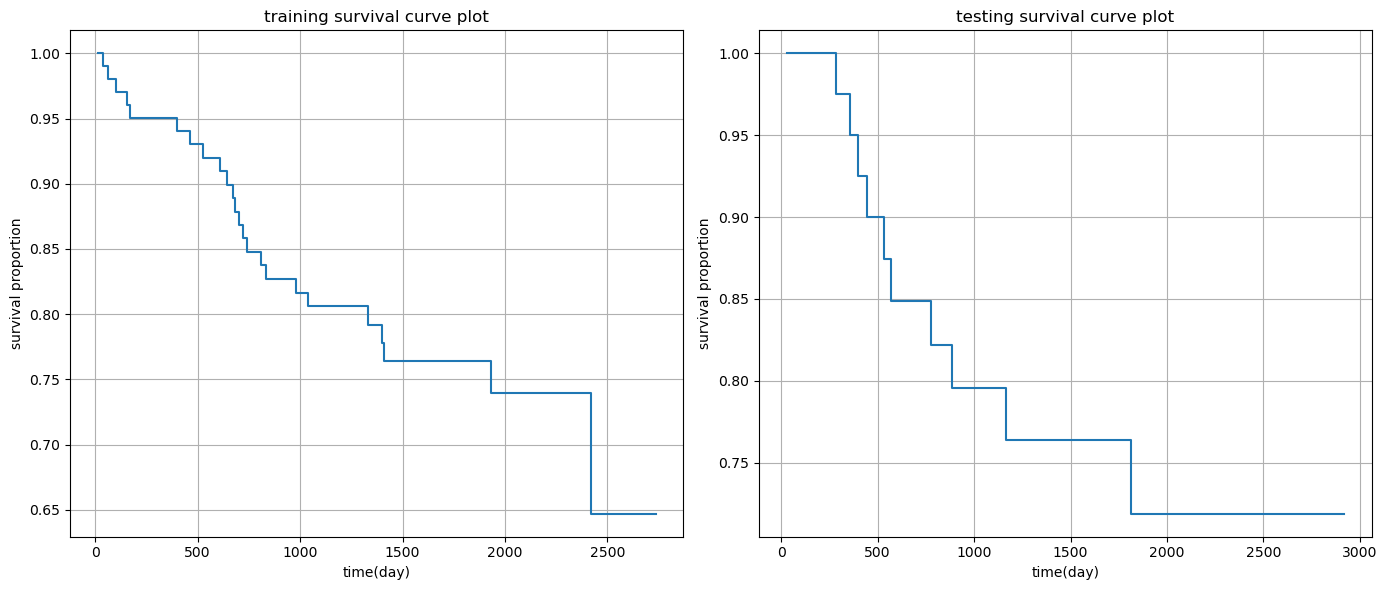

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

time_train, survival_prob_train = kaplan_meier_estimator(y_train['event'], y_train['time'])
ax1.step(time_train, survival_prob_train, where="post")
ax1.set_title("training survival curve plot")
ax1.set_xlabel("time(day)")
ax1.set_ylabel("survival proportion")
ax1.grid(True)

time_test, survival_prob_test = kaplan_meier_estimator(y_test['event'], y_test['time'])
ax2.step(time_test, survival_prob_test, where="post")
ax2.set_title("testing survival curve plot")
ax2.set_xlabel("time(day)")
ax2.set_ylabel("survival proportion")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [91]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

# Save each set to its own CSV file
X_train.to_csv(f'X_train_{n}_HR_FDR.csv', index=False)
X_test.to_csv(f'X_test_{n}_HR_FDR.csv', index=False)
y_train_df.to_csv(f'y_train_{n}_HR_FDR.csv', index=False)
y_test_df.to_csv(f'y_test_{n}_HR_FDR.csv', index=False)

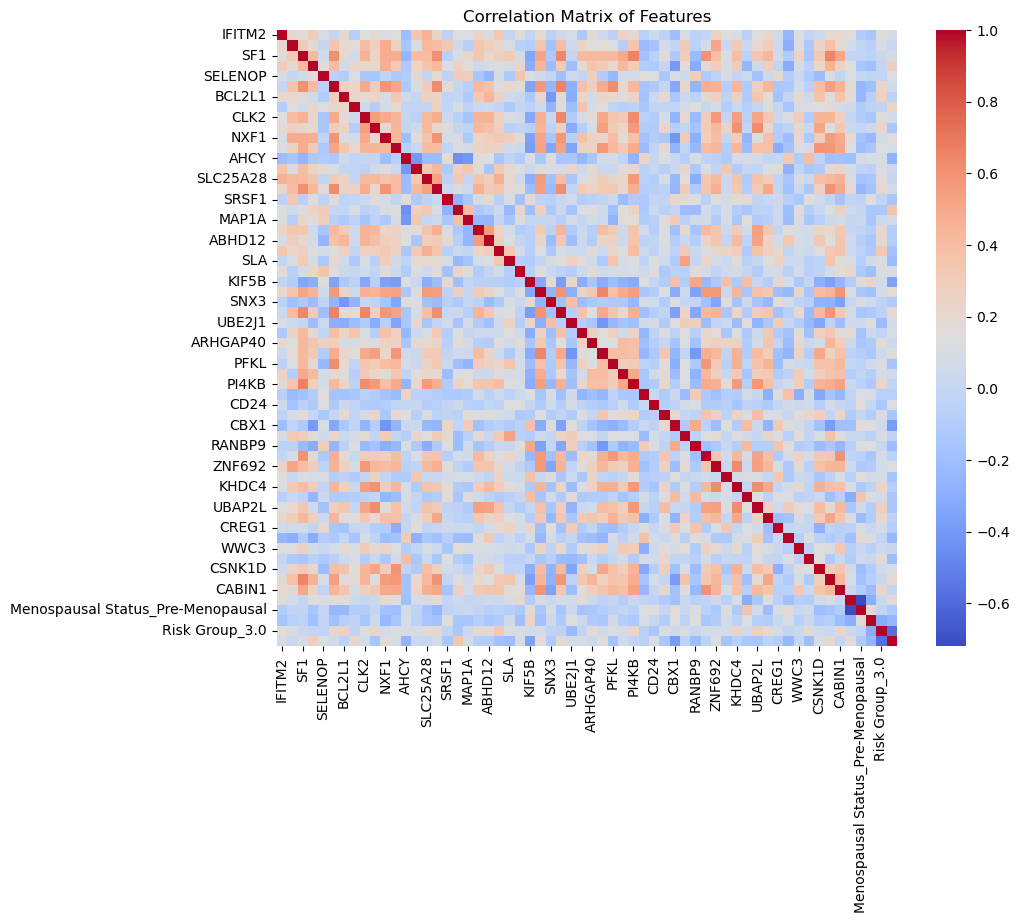

high correlation pairs:
Series([], dtype: bool)


In [54]:
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features')
plt.show()

high_corr_pairs = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_indices = high_corr_pairs.stack()[high_corr_pairs.stack()]

print("high correlation pairs:")
print(high_corr_indices)

In [ ]:
# X_scaled.to_csv(f'{file_path}/X_scaled.csv')


#### 1. Random Forest (RF)
RF is often used for classification or regression, where we use it as a classification model to predict whether an event will occur (event).

`n_estimators`: The number of trees

`random_state`: to ensure that the result can be reproduced


In [38]:
from sksurv.ensemble import RandomSurvivalForest

rsf_model = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf_model.fit(X_train, y_train)

risk_scores_rsf = rsf_model.predict(X)

risk_scores_train = rsf_model.predict(X_train)
risk_scores_test = rsf_model.predict(X_test)

print(len(risk_scores_rsf)) ## 150 predicted outcomes

surv_funcs_train = rsf_model.predict_survival_function(X_train)
surv_funcs_test = rsf_model.predict_survival_function(X_test)

print(f"Number of survival functions for the training set: {len(surv_funcs_train)}")
print(f"Number of survival functions for the testing set: {len(surv_funcs_test)}")

150
Number of survival functions for the training set: 105
Number of survival functions for the testing set: 45


In [39]:
c_index_train = concordance_index_censored(
    y_train['event'], y_train['time'], risk_scores_train
)[0]
c_index_test = concordance_index_censored(
    y_test['event'], y_test['time'], risk_scores_test
)[0]
print(f"C-index for the training set: {c_index_train:.4f}")
print(f"C-index for the testing set: {c_index_test:.4f}")

C-index for the training set: 0.9649
C-index for the testing set: 0.6981


In [16]:
time_point = 365 * 1

print('------ Time-Dependent AUC ------')
auc_train = concordance_index_ipcw(
    y_train, y_train, risk_scores_train, tau=time_point
)[0]
auc_test = concordance_index_ipcw(
    y_train, y_test, risk_scores_test, tau=time_point
)[0]

print(f"training set in {time_point} days has Time-Dependent AUC: {auc_train:.4f}")
print(f"testing set in {time_point} days has Time-Dependent AUC: {auc_test:.4f}")

print('------ Brier Score ------')
surv_funcs_train = rsf_model.predict_survival_function(X_train)
surv_funcs_test = rsf_model.predict_survival_function(X_test)

surv_prob_train = np.array([f(time_point) for f in surv_funcs_train])
surv_prob_test = np.array([f(time_point) for f in surv_funcs_test])

score_train = brier_score(y_train, y_train, surv_prob_train, time_point)[1]
score_test = brier_score(y_train, y_test, surv_prob_test, time_point)[1]

print(f"training set in {time_point} days has Brier Score: {score_train}")
print(f"testing set in {time_point} days has Brier Score: {score_test}")

------ Time-Dependent AUC ------
training set in 365 days has Time-Dependent AUC: 0.9753
testing set in 365 days has Time-Dependent AUC: 0.6623
------ Brier Score ------
training set in 365 days has Brier Score: [0.02616207]
testing set in 365 days has Brier Score: [0.04210636]


In [ ]:
# rs_median = np.median(risk_scores_rsf)
# # print(rs_median) ## 3.829275793650794
# rs_grps = np.where(risk_scores_rsf > rs_median, 'High_rs', 'Low_rs')
# survival_val['Risk_Score'] = rs_grps

# print(survival_val)
# kmf = KaplanMeierFitter()
# high_risk_grp = survival_val[survival_val['Risk_Score'] == 'High_rs']
# kmf.fit(durations = high_risk_grp['Time to event if any (days)'], event_observed = high_risk_grp['IDFS Event'], label='High Risk Score')
# ax = kmf.plot_survival_function()

# low_risk_grp = survival_val[survival_val['Risk_Score'] == 'Low_rs']
# kmf.fit(durations = low_risk_grp['Time to event if any (days)'], event_observed = low_risk_grp['IDFS Event'], label='Low Risk Score')
# kmf.plot_survival_function(ax=ax)

# plt.title('KaplanMeierFitter for Groups by Median')
# plt.xlabel('Time to events(days)')
# plt.ylabel('Survival Probability')
# plt.grid(True)
# plt.show()


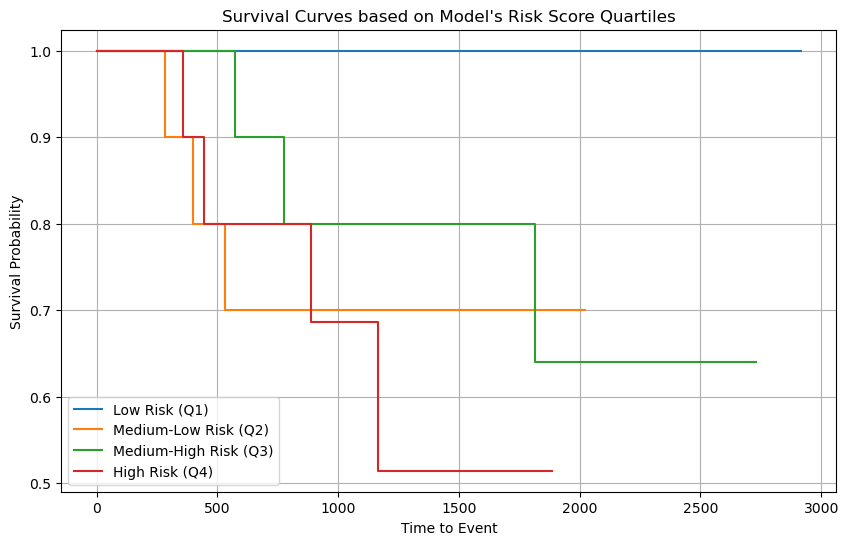

In [173]:
quantile_survival_plot(risk_scores_test)

(np.float64(102.17221441904985), np.float64(5.301294129139545e-22))


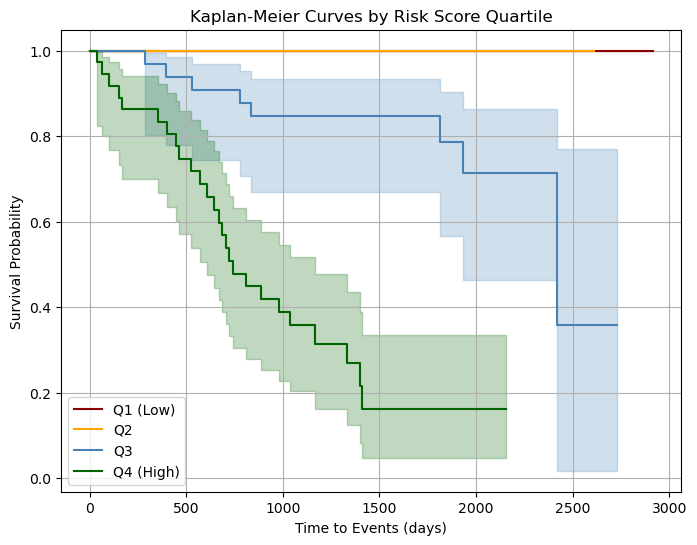

In [14]:
quartiles = np.quantile(risk_scores_rsf, [0.25, 0.5, 0.75])
def categorize_risk(score):
    if score <= quartiles[0]:
        return 'Q1 (Low)'
    elif score <= quartiles[1]:
        return 'Q2'
    elif score <= quartiles[2]:
        return 'Q3'
    else:
        return 'Q4 (High)'

df = survival_val.copy()
df['Risk_Group_Quartile'] = np.vectorize(categorize_risk)(risk_scores_rsf)

y_structured = Surv.from_arrays(
    event=df['IDFS Event'].values.astype(bool),
    time=df['Time to event if any (days)'].values
)
group_labels = df['Risk_Group_Quartile'].values
results = compare_survival(y_structured, group_labels)
print(results)

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(8, 6))

for group_name, color in zip(['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], ['darkred', 'orange', 'steelblue', 'darkgreen']):
    group_data = df[df['Risk_Group_Quartile'] == group_name]
    kmf.fit(durations=group_data['Time to event if any (days)'], event_observed=group_data['IDFS Event'], label=group_name)
    kmf.plot_survival_function(ax=ax, color=color)
plt.title('Kaplan-Meier Curves by Risk Score Quartile')
plt.xlabel('Time to Events (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

#### 2. Cox Regression (CoxPH)

Cox Proportional risk model, which is the standard survival analysis model

Note: The model of the lifelines library usually requires a single DataFrame that contains all the data (features, time, and events).

instead of separate X and y, and it is insensitive to data scaling

In [18]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [54]:
train_df_cph = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train)], axis=1)
test_df_cph = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test)], axis=1)

duration_col = 'time'
event_col = 'event'

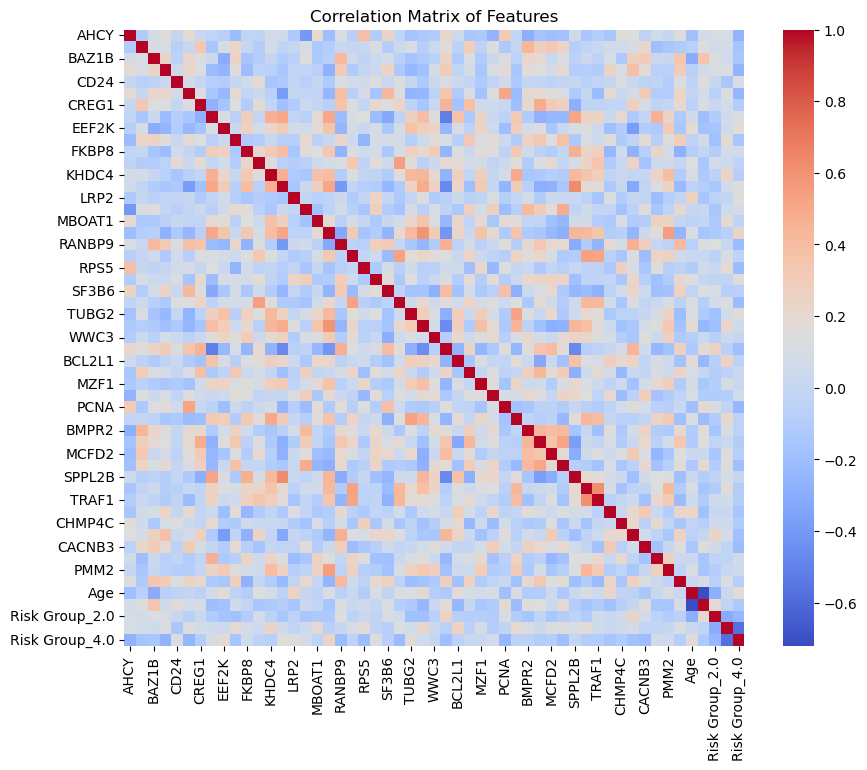

high correlation pairs:
Series([], dtype: bool)


In [55]:
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features')
plt.show()

high_corr_pairs = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_indices = high_corr_pairs.stack()[high_corr_pairs.stack()]

print("high correlation pairs:")
print(high_corr_indices)

In [56]:
non_numeric_cols = train_df_cph.select_dtypes(exclude=[np.float64, np.int64]).columns

print(non_numeric_cols)
if not non_numeric_cols.empty:
    print(train_df_cph[non_numeric_cols].head())
else:
    print("No numeric cols")


bool_cols = train_df_cph.select_dtypes(include='bool').columns

if not bool_cols.empty:
    print(train_df_cph[bool_cols].sum())
else:
    print("No bool types cols")

Index(['Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0', 'event'],
      dtype='object')
   Menospausal Status_Pre-Menopausal  Risk Group_2.0  Risk Group_3.0  \
0                              False           False           False   
1                               True           False            True   
2                              False           False           False   
3                              False           False           False   
4                              False           False            True   

   Risk Group_4.0  event  
0            True  False  
1           False  False  
2            True  False  
3            True  False  
4           False  False  
Menospausal Status_Pre-Menopausal    28
Risk Group_2.0                       12
Risk Group_3.0                       44
Risk Group_4.0                       33
event                                24
dtype: int64


In [ ]:
# cph = CoxPHFitter(penalizer=0.01)

cph = CoxPHFitter()
cph.fit(train_df_cph, duration_col=duration_col, event_col=event_col)
cph.print_summary()

risk_scores_train = cph.predict_partial_hazard(X_train)
risk_scores_test = cph.predict_partial_hazard(X_test)

/Users/yuzimeng/anaconda3/envs/ml_env/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


In [58]:
# Calculate C-index for the training set
c_index_train = concordance_index(
    train_df_cph[duration_col], risk_scores_train, train_df_cph[event_col]
)

# Calculate C-index for the testing set
c_index_test = concordance_index(
    test_df_cph[duration_col], risk_scores_test, test_df_cph[event_col]
)

print(f"C-index for training set: {c_index_train:.4f}")
print(f"C-index for testing set: {c_index_test:.4f}")

C-index for training set: 0.0564
C-index for testing set: 0.3239


(np.float64(3.3579453815920917), np.float64(0.3396588113057643))


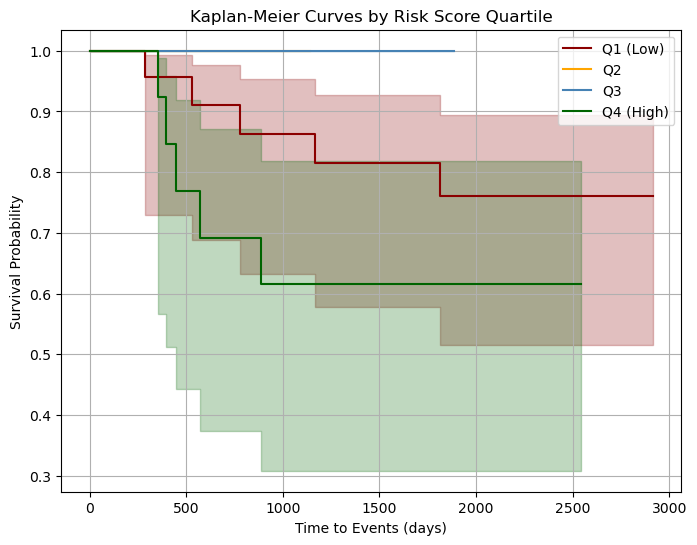

In [59]:
quartile_breaks = np.quantile(risk_scores_test, q=[0.25, 0.5, 0.75])

def categorize_risk(score):
    if score <= quartiles[0]:
        return 'Q1 (Low)'
    elif score <= quartiles[1]:
        return 'Q2'
    elif score <= quartiles[2]:
        return 'Q3'
    else:
        return 'Q4 (High)'

df = test_df_cph.copy()
df['Risk_Group_Quartile'] = np.vectorize(categorize_risk)(risk_scores_test)

y_structured = Surv.from_arrays(
    event=df['event'].values.astype(bool),
    time=df['time'].values
)
group_labels = df['Risk_Group_Quartile'].values
results = compare_survival(y_structured, group_labels)
print(results)

kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(8, 6))

for group_name, color in zip(['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'], ['darkred', 'orange', 'steelblue', 'darkgreen']):
    group_data = df[df['Risk_Group_Quartile'] == group_name]
    kmf.fit(durations=group_data['time'], event_observed=group_data['event'], label=group_name)
    kmf.plot_survival_function(ax=ax, color=color)
plt.title('Kaplan-Meier Curves by Risk Score Quartile')
plt.xlabel('Time to Events (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [34]:
risk_scores_test.shape

(45,)

In [39]:
print(risk_scores_test[risk_scores_test < 1e-5])
print(np.isinf(risk_scores_test).any())

0DTPGY    0.000003
dtype: float64
False


In [24]:
# Define the time points in days
time_points = [365, 365 * 3, 365 * 5]

# Convert y_train and y_test to NumPy structured arrays if not already
# This is a good practice for sksurv metric functions
y_train_sk = Surv.from_arrays(event=y_train['event'], time=y_train['time'])
y_test_sk = Surv.from_arrays(event=y_test['event'], time=y_test['time'])

print("\n--- Time-Dependent AUC ---")
for t in time_points:
    auc_test = concordance_index_ipcw(y_train_sk, y_test_sk, risk_scores_test, tau=t)[0]
    print(f"Time-Dependent AUC at {t} days: {auc_test:.4f}")

print("\n--- Brier Score ---")
# Predict survival probabilities for the specific time points
survival_probs_test = cph.predict_survival_function(X_test, times=time_points)

for i, t in enumerate(time_points):
    # The brier_score function needs the original data for weighting
    b_score_test = brier_score(y_train_sk, y_test_sk, survival_probs_test.iloc[i], t)[1]
    print(f"Brier Score at {t} days: {b_score_test}")
    
print("\n--- Training Set Time-Dependent AUC ---")
for t in time_points:
    auc_train = concordance_index_ipcw(y_train_sk, y_train_sk, risk_scores_train, tau=t)[0]
    print(f"Time-Dependent AUC at {t} days: {auc_train:.4f}")

# And the original code for the test set
print("\n--- Testing Set Time-Dependent AUC ---")
for t in time_points:
    auc_test = concordance_index_ipcw(y_train_sk, y_test_sk, risk_scores_test, tau=t)[0]
    print(f"Time-Dependent AUC at {t} days: {auc_test}")


--- Time-Dependent AUC ---
Time-Dependent AUC at 365 days: 0.7403
Time-Dependent AUC at 1095 days: 0.7144
Time-Dependent AUC at 1825 days: 0.6080

--- Brier Score ---
Brier Score at 365 days: [0.03852822]
Brier Score at 1095 days: [0.22345874]
Brier Score at 1825 days: [0.18775925]

--- Training Set Time-Dependent AUC ---
Time-Dependent AUC at 365 days: 0.9548
Time-Dependent AUC at 1095 days: 0.9497
Time-Dependent AUC at 1825 days: 0.9539

--- Testing Set Time-Dependent AUC ---
Time-Dependent AUC at 365 days: 0.7402597402597403
Time-Dependent AUC at 1095 days: 0.7144246532595802
Time-Dependent AUC at 1825 days: 0.6080136662988471


In [60]:
# survival_df = survival_val[['Time to event if any (days)','IDFS Event']]
# lifelines_df = pd.concat([X,survival_df], axis=1)
# print(lifelines_df.columns)

# cph = CoxPHFitter()
# cph.fit(lifelines_df, duration_col='Time to event if any (days)', event_col='IDFS Event')


In [ ]:
# X.to_csv(file_path + '/scaled_genes_age_meno_risk.csv')

In [ ]:
# survival_df.to_csv(file_path + '/survival_time_event.csv')

#### 2.1 Lasso-Cox

In [ ]:
# cph = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
# cph.fit(lifelines_df, duration_col='Time to event if any (days)', event_col='IDFS Event')
# # cph.print_summary()
# print(len(cph.params_[cph.params_ != 0].index.tolist()))

<lifelines.CoxPHFitter: fitted with 150 total observations, 116 right-censored observations>
             duration col = 'Time to event if any (days)'
                event col = 'IDFS Event'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 150
number of events observed = 34
   partial log-likelihood = -106.70
         time fit was run = 2025-09-02 20:27:39 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
SERINC1                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
WDR6                               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
INTS3                              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PIP5K1A                           -0.35      0.71      0.61           -1.55            0.85                0.21                2.34
TMEM259                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ARGLU1                             0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NXF1                               0.58      1.78      0.57           -0.54            1.70                0.58                5.46
SNX3                              -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
KAT2A                             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CLCN7                             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
AHCY                               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CSNK1D                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ELK3                               0.64      1.90      0.48           -0.29            1.58                0.75                4.84
SLC25A28                           0.16      1.17      0.51           -0.84            1.16                0.43                3.19
DELE1                             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ABHD12                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PARP4                             -0.12      0.89      0.40           -0.89            0.66                0.41                1.93
SLA                               -0.30      0.74      0.53           -1.34            0.74                0.26                2.09
SPPL2B                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NREP                               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
RANBP9                             0.73      2.08      0.44           -0.13            1.59                0.88                4.91
BCL2L1                            -0.68      0.51      0.49           -1.65            0.29                0.19                1.34
LGALS3BP                          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
FKBP8                              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
YPEL3                             -0.00      1.00      0.00           -0.00            0.00                1.00        

126


#### 3.Aalen's Additive Model

Unlike the Cox model, it assumes that the effects of covariates are additive rather than multipliative.

In [67]:
print(lifelines_df[['Menospausal Status_Pre-Menopausal','Risk Group_2.0', 'Risk Group_3.0', 'Risk Group_4.0']].corr())
print(selected_genes.corr())

                                   Menospausal Status_Pre-Menopausal  \
Menospausal Status_Pre-Menopausal                           1.000000   
Risk Group_2.0                                              0.175712   
Risk Group_3.0                                             -0.027845   
Risk Group_4.0                                             -0.065291   

                                   Risk Group_2.0  Risk Group_3.0  \
Menospausal Status_Pre-Menopausal        0.175712       -0.027845   
Risk Group_2.0                           1.000000       -0.303547   
Risk Group_3.0                          -0.303547        1.000000   
Risk Group_4.0                          -0.228665       -0.624695   

                                   Risk Group_4.0  
Menospausal Status_Pre-Menopausal       -0.065291  
Risk Group_2.0                          -0.228665  
Risk Group_3.0                          -0.624695  
Risk Group_4.0                           1.000000  
          SERINC1      WDR6     I

In [70]:
highly_correlated_genes = []
for i in range(len(lifelines_df.columns)-7):
    for j in range(i):
        if abs(lifelines_df.iloc[i, j]) > 0.999:
            colname_i = lifelines_df.columns[i]
            colname_j = lifelines_df.columns[j]
            highly_correlated_genes.append(colname_i)
            print(f"发现共线性的基因：{colname_i} 和 {colname_j}")
            
cleaned_gene_names = [g for g in lifelines_df if g not in highly_correlated_genes]

发现共线性的基因：TMEM259 和 SERINC1
发现共线性的基因：NXF1 和 ARGLU1
发现共线性的基因：SNX3 和 SERINC1
发现共线性的基因：SNX3 和 PIP5K1A
发现共线性的基因：SNX3 和 ARGLU1
发现共线性的基因：CLCN7 和 SERINC1
发现共线性的基因：CLCN7 和 WDR6
发现共线性的基因：CLCN7 和 INTS3
发现共线性的基因：CLCN7 和 ARGLU1
发现共线性的基因：AHCY 和 PIP5K1A
发现共线性的基因：AHCY 和 ARGLU1
发现共线性的基因：AHCY 和 NXF1
发现共线性的基因：AHCY 和 KAT2A
发现共线性的基因：CSNK1D 和 NXF1
发现共线性的基因：ELK3 和 SERINC1
发现共线性的基因：ELK3 和 WDR6
发现共线性的基因：ELK3 和 TMEM259
发现共线性的基因：ELK3 和 KAT2A
发现共线性的基因：ELK3 和 CLCN7
发现共线性的基因：ELK3 和 AHCY
发现共线性的基因：SLC25A28 和 PIP5K1A
发现共线性的基因：SLC25A28 和 ARGLU1
发现共线性的基因：SLC25A28 和 ELK3
发现共线性的基因：DELE1 和 SERINC1
发现共线性的基因：DELE1 和 INTS3
发现共线性的基因：DELE1 和 ARGLU1
发现共线性的基因：DELE1 和 ELK3
发现共线性的基因：ABHD12 和 AHCY
发现共线性的基因：ABHD12 和 ELK3
发现共线性的基因：PARP4 和 SERINC1
发现共线性的基因：PARP4 和 PIP5K1A
发现共线性的基因：PARP4 和 TMEM259
发现共线性的基因：PARP4 和 ARGLU1
发现共线性的基因：PARP4 和 NXF1
发现共线性的基因：PARP4 和 KAT2A
发现共线性的基因：PARP4 和 CLCN7
发现共线性的基因：PARP4 和 CSNK1D
发现共线性的基因：PARP4 和 DELE1
发现共线性的基因：SLA 和 SERINC1
发现共线性的基因：SLA 和 AHCY
发现共线性的基因：SLA 和 ELK3
发现共线性的基因：SPPL2B 和 INTS3
发现共线性的基因：SPPL2B 和

In [75]:
from lifelines import AalenAdditiveFitter

aaf = AalenAdditiveFitter(fit_intercept=False)

print(len(cleaned_gene_names))
print(lifelines_df[cleaned_gene_names])

aaf.fit(lifelines_df, duration_col='Time to event if any (days)', event_col='IDFS Event')
aaf.print_summary()

15
            SERINC1      WDR6     INTS3   PIP5K1A    ARGLU1     KAT2A  \
Sample_ID                                                               
0DTPRC    -0.425901 -0.533689  1.076433  1.373374  0.548149  0.369720   
0DTPIS    -0.842216 -2.010823  0.201605 -1.484453 -2.339565 -1.847972   
0DTPIJ     0.773591  0.860349  3.603064  2.229372  2.174995  1.542498   
0DTPGY    -0.027900  0.467411  0.717093  0.183670  1.448364  1.586918   
0DTPRG     1.018772  0.206696  0.868532  0.234172 -0.029080 -0.086533   
...             ...       ...       ...       ...       ...       ...   
0E0EHZ     1.378122  0.782234  0.549350  0.276737 -0.200818 -0.052374   
0E0EK8     0.561573  2.782921  0.533306  0.014385  2.576060  0.469260   
0E0EHO    -0.960538 -0.824700 -0.896063 -0.458063 -0.571474 -0.805082   
0E0EGY     0.320247 -0.211579  0.266266  0.172177 -1.324928 -0.867108   
0E0EGR    -0.099602  2.173725 -0.280822  0.234123  1.267503 -0.334121   

               NREP     FKBP8   Age  Menospausa

<lifelines.AalenAdditiveFitter: fitted with 150 total observations, 116 right-censored observations>
             duration col = 'Time to event if any (days)'
                event col = 'IDFS Event'
       number of subjects = 150
number of events observed = 34
         time fit was run = 2025-09-01 17:28:16 UTC

---
Empty DataFrame
Columns: []
Index: [SERINC1, WDR6, INTS3, PIP5K1A, TMEM259, ARGLU1, NXF1, SNX3, KAT2A, CLCN7, AHCY, CSNK1D, ELK3, SLC25A28, DELE1, ABHD12, PARP4, SLA, SPPL2B, NREP, RANBP9, BCL2L1, LGALS3BP, FKBP8, YPEL3, WWC3, KIF5B, CBX1, JADE2, UBE2J1, ZNF692, RESF1, TRAF1, CCND1, PCP2, SLC25A23, HERPUD1, KLF10, SUGP2, PFKL, GGA3, ARHGAP40, PCNA, SRSF1, C1QA, SETDB1, CPNE1, MCFD2, SET, SF3B6, TEP1, GNAQ, TUBG2, ITGB1, NPIPB5, PRKD2, MTPN, ZFYVE27, RPL10, MGRN1, CTTN, ENC1, PCYOX1, TTC9, RPS5, CD164, CSGALNACT2, HOOK2, NCOA5, ACTR2, PLK2, TMEM140, CLIC1, IFITM2, TMEM101, ATP1B1, CABIN1, NPIPB3, RAB11FIP1, UBAP2L, SPON1, KHDC4, ILF3, SIN3B, MAP1A, VPS37B, ARHGEF37, RNF44, NEURL1B, LRP2, LPIN3, BAZ1B, SLC25A25, CEACAM6, SEC63, TNPO2, LHFPL2, PHF8, EEF2K, PER3, ...]
---
Concordance = 0.55

#### 4.Survival Support Vector Model

Apply the principles of support vector machines (SVMs) to survival data. It aims to find a hyperplane that maximizes the difference between the time of occurrence of an event and the time of review.

[survival-SVM link](https://scikit-survival.readthedocs.io/en/latest/user_guide/survival-svm.html)

<img src='./survival_SVM.png'>

In [139]:
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from sksurv.column import encode_categorical
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

In [140]:
n_censored = y_train.shape[0] - y_train['event'].sum()
print(f"{n_censored / y_train.shape[0] * 100:.1f}% of records are censored")

77.1% of records are censored


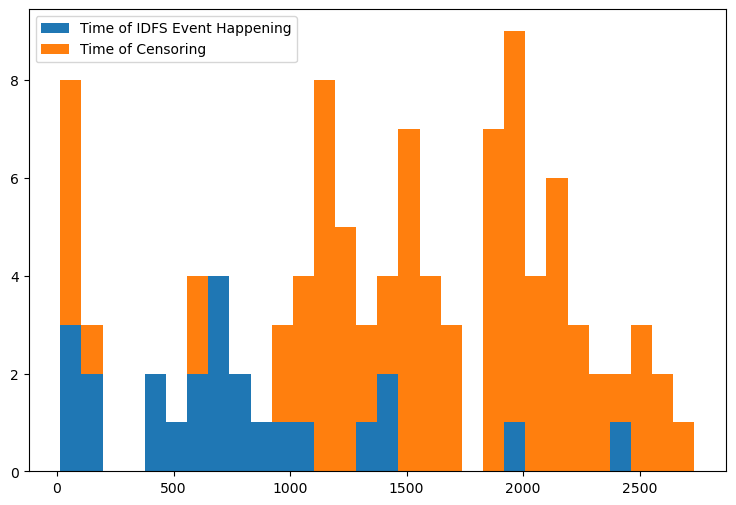

In [141]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist(
    (y_train["time"][y_train["event"]], y_train["time"][~y_train["event"]]), bins=30, stacked=True
)
_ = plt.legend(patches, ["Time of IDFS Event Happening", "Time of Censoring"])

In [142]:
model = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
model.fit(X_train, y_train)

def score_survival_model(model, X_test, y_test):
    risk_scores_test = model.predict(X_test)
    result = concordance_index_censored(y_test["event"], y_test["time"], risk_scores_test)
    return result[0]

param_grid = {"alpha": [2.0**v for v in range(-12, 13, 2)]}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(model, param_grid, scoring=score_survival_model, n_jobs=1, refit=False, cv=cv)

import warnings
## 使用GridSearchCV在训练集上进行交叉验证调优
warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(X_train, y_train)

In [143]:
f"cross-validation in train set mean c-index score: {gcv.best_score_:.3f}", gcv.best_params_

('cross-validation in train set mean c-index score: 0.798',
 {'alpha': 0.000244140625})

In [158]:
best_alpha = gcv.best_params_['alpha']

final_model = FastSurvivalSVM(alpha=best_alpha, max_iter=1000, tol=1e-5, random_state=0)
final_model.fit(X_train, y_train)

final_score = score_survival_model(final_model, X_test, y_test)
print(f"C-index in testig set: {final_score:.4f}")

pred_rs = final_model.predict(X_test)

C-index in testig set: 0.7642


In [159]:
pred_rs

array([-0.40245007,  0.37137773, -0.31149157, -0.04299413,  0.3951455 ,
       -0.51857676,  0.10948702,  0.45611813,  0.12778196, -0.23218142,
       -0.14723273, -0.10843677,  0.66864353, -0.30211937,  0.04713221,
        0.08901449,  0.1388863 ,  0.68765111,  0.37185406,  0.21768438,
       -0.10436926,  0.05641285,  0.05481399,  0.10884708, -0.17169994,
       -0.75200546,  0.64930121, -0.2624534 , -0.00641329,  0.5951248 ,
        0.26064764, -0.43905665,  0.13919331, -0.73172824,  0.10419823,
        0.10401636, -0.71042863, -0.114187  , -0.26389407,  0.28714784,
        0.24504978,  0.15061771, -0.42590086, -0.24063834,  0.15978525])

In [163]:
quantiles = np.quantile(pred_rs, [0.25, 0.5, 0.75])
print(quantiles)

group_labels = [
    'Low Risk (Q1)', 
    'Medium-Low Risk (Q2)', 
    'Medium-High Risk (Q3)', 
    'High Risk (Q4)'
]
masks = [
    pred_rs <= quantiles[0],
    (pred_rs > quantiles[0]) & (pred_rs <= quantiles[1]),
    (pred_rs > quantiles[1]) & (pred_rs <= quantiles[2]),
    pred_rs > quantiles[2]
]

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

[-0.24063834  0.05641285  0.21768438]


<Figure size 1000x600 with 0 Axes>

In [164]:
y_test[mask]['time']

array([[2065., 1358., 1936., 1544.,  571.,  742.,   28., 1099., 2156.,
          77., 1981.,  254.,  176., 2020., 1131., 1443., 1345., 1166.,
        1140., 1840., 2545., 1158., 1473.,  514., 1526.,   68.,  445.,
        1959., 2232.,  356.,  888., 1813.,  777., 1955.,  285.,  398.,
        2729., 2107., 1815., 1887., 1103., 1485., 2917., 2241.,  532.]])

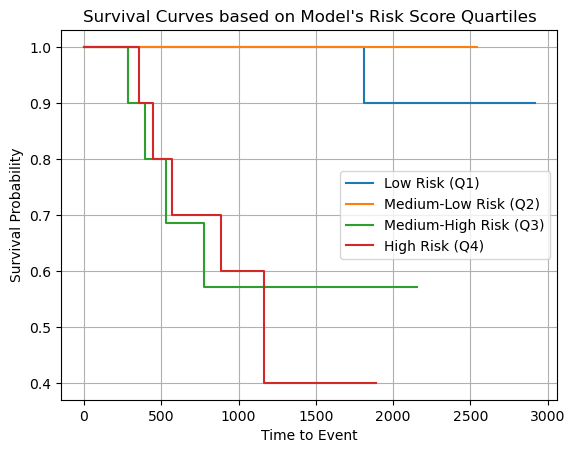

In [165]:
for i, mask in enumerate(masks):
    # Check if the group is empty
    if np.any(mask):
        # Flatten the arrays to ensure they are 1D
        time_data = y_test[mask]['time'].flatten()
        event_data = y_test[mask]['event'].flatten()
        
        kmf.fit(time_data, event_data, label=group_labels[i])
        kmf.plot_survival_function(ci_show=False)
    else:
        print(f"Skipping empty group: {group_labels[i]}")

# 5. Add titles and labels
plt.title("Survival Curves based on Model's Risk Score Quartiles")
plt.xlabel("Time to Event")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


In [90]:
def plot_performance(gcv):
    n_splits = gcv.cv.n_splits
    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []
    for i, params in enumerate(gcv.cv_results_["params"]):
        name = f'{params["alpha"]:.5f}'
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_[f"split{j}_test_score"][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)
    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", hue="alpha", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

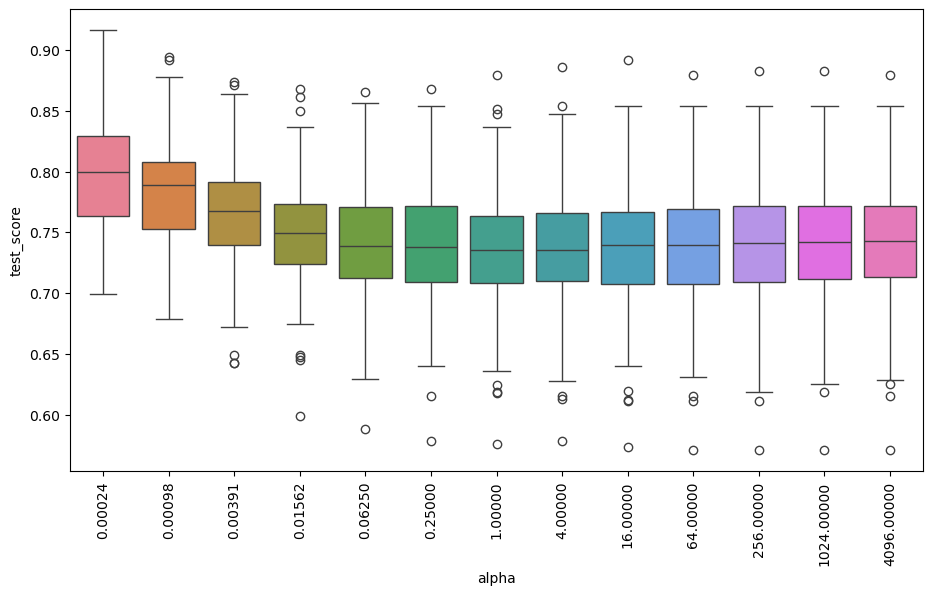

In [91]:
plot_performance(gcv)

In [102]:
pred = model.predict(X_test)
print(np.round(pred, 3))
print(y_test)

[-1.1156e+01  1.1970e+00 -5.6290e+00 -1.0400e+00  6.2690e+00 -6.5750e+00
  1.8410e+00  6.4460e+00 -4.4200e-01  2.4500e-01 -1.0850e+00 -5.0100e-01
  8.1000e-02 -2.7420e+00 -1.1070e+00  4.0300e+00  8.9500e-01  7.6530e+00
  4.7070e+00  2.7410e+00  2.8290e+00  2.2770e+00  3.1520e+00 -4.1890e+00
 -8.3600e-01 -7.8520e+00  5.6730e+00 -4.2020e+00  1.7680e+00  9.8020e+00
  3.0790e+00 -4.1910e+00  8.2600e-01 -1.8928e+01 -6.0000e-03 -1.2430e+00
 -1.4251e+01  1.3380e+00 -1.2460e+00  4.2740e+00  3.9990e+00  5.5900e-01
 -2.7610e+00 -4.1720e+00  2.2490e+00]
[(False, 2065.) (False, 1358.) (False, 1936.) (False, 1544.)
 ( True,  571.) (False,  742.) (False,   28.) (False, 1099.)
 (False, 2156.) (False,   77.) (False, 1981.) (False,  254.)
 (False,  176.) (False, 2020.) (False, 1131.) (False, 1443.)
 (False, 1345.) ( True, 1166.) (False, 1140.) (False, 1840.)
 (False, 2545.) (False, 1158.) (False, 1473.) (False,  514.)
 (False, 1526.) (False,   68.) ( True,  445.) (False, 1959.)
 (False, 2232.) ( True, 

In [83]:
time_points = [365, 365 * 3, 365 * 5]

for threshold in time_points:
    print(f"======================================================")
    print(f"      Evaluating SVM at {threshold} days ({threshold/365:.0f}-year)")
    print(f"======================================================")

    # 2. Create the Binary Target Variable for Training
    # A patient is a '1' if they had an event before or at the threshold.
    y_train_binary = np.where(
        (y_train['time'] <= threshold) & (y_train['event'] == True), 
        1, 
        0
    )

    # 3. Create the Binary Target Variable for Testing
    # This must be done separately for the test set.
    y_test_binary = np.where(
        (y_test['time'] <= threshold) & (y_test['event'] == True), 
        1, 
        0
    )
    
    # 4. Train and Evaluate the SVM Model
    # Use the new binary target variables for each time point.
    svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
    svm_model.fit(X_train, y_train_binary)
    y_pred = svm_model.predict(X_test)

    # 5. Print the Results
    print(f"Test set accuracy: {accuracy_score(y_test_binary, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_pred))
    print(f"Number of support vectors per class: {svm_model.n_support_}")
    print("\n")

      Evaluating SVM at 365 days (1-year)
Test set accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.33      0.50      0.40         2

    accuracy                           0.93        45
   macro avg       0.65      0.73      0.68        45
weighted avg       0.95      0.93      0.94        45

Number of support vectors per class: [27  5]


      Evaluating SVM at 1095 days (3-year)
Test set accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        37
           1       0.27      0.38      0.32         8

    accuracy                           0.71        45
   macro avg       0.56      0.58      0.57        45
weighted avg       0.75      0.71      0.73        45

Number of support vectors per class: [38 18]


      Evaluating SVM at 1825 days (5-year)
Test set accuracy: 0.69

Cla

In [ ]:


# lifelines_df['Risk_Category'] = np.where(
#     (lifelines_df['Time to event if any (days)'] <= survival_threshold) & 
#     (lifelines_df['IDFS Event'] == 1), 
#     1, 
#     0
# )
# X = lifelines_df.drop(columns=['Time to event if any (days)', 'IDFS Event', 'Risk_Category'])
# y = lifelines_df['Risk_Category']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train) ## X is feature training, y is risk category

y_pred = svm_model.predict(X_test)
# risk_scores_svm = svm_model.predict(X)
# risk_scores_svm[:5]

print("--- SVM model evaluation report ---")
print(f"accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nclassification report:")
print(classification_report(y_test, y_pred))
print(f"support vector: {svm_model.n_support_}")

--- SVM model evaluation report ---
accuracy: 0.76

classification report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85        39
           1       0.27      0.50      0.35         6

    accuracy                           0.76        45
   macro avg       0.59      0.65      0.60        45
weighted avg       0.83      0.76      0.78        45

support vector: [30 17]


In [105]:
y_train.value_counts()

Risk_Category
0    84
1    21
Name: count, dtype: int64

#### 5.XGBoost for survival version

Consists of a decision tree and is an extension of Random Forest in survival analysis. It predicts an individual's survival function by averaging the survival tree on multiple subsamples.

In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

**5.1 gradient boosting on Cox’s partial likelihood with regression trees base learners**


We can see that the performance quickly improves, but also that the performance starts to decrease if the ensemble becomes too big.

In [166]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)

boost_rs = est_cph_tree.predict(X_test)

cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.701


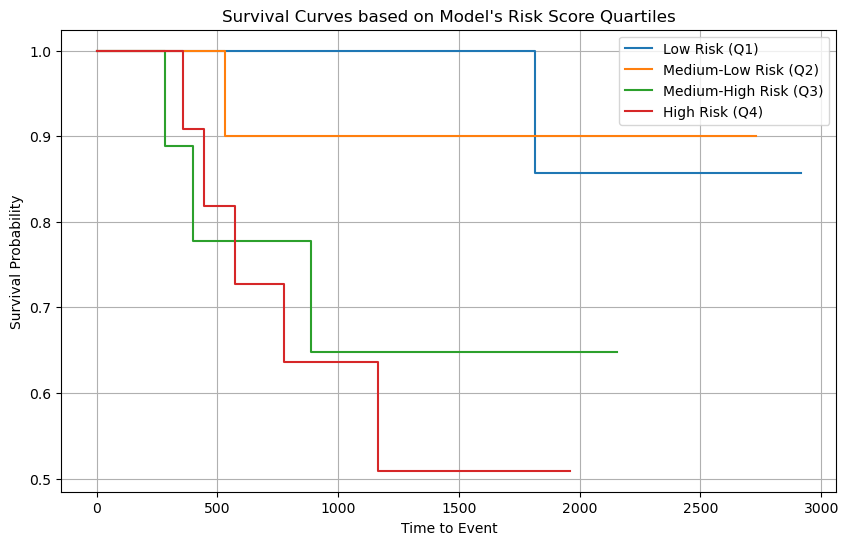

In [167]:
# 2. Get the quartiles
quantiles = np.quantile(boost_rs, [0.25, 0.5, 0.75])

# 3. Define the groups and their labels
group_labels = [
    'Low Risk (Q1)', 
    'Medium-Low Risk (Q2)', 
    'Medium-High Risk (Q3)', 
    'High Risk (Q4)'
]
masks = [
    boost_rs <= quantiles[0],
    (boost_rs > quantiles[0]) & (boost_rs <= quantiles[1]),
    (boost_rs > quantiles[1]) & (boost_rs <= quantiles[2]),
    boost_rs > quantiles[2]
]

# 4. Plot the Kaplan-Meier survival curves with error handling
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for i, mask in enumerate(masks):
    # Check if the group is empty
    if np.any(mask):
        # Flatten the arrays to ensure they are 1D
        time_data = y_test[mask]['time'].flatten()
        event_data = y_test[mask]['event'].flatten()
        
        kmf.fit(time_data, event_data, label=group_labels[i])
        kmf.plot_survival_function(ci_show=False)
    else:
        print(f"Skipping empty group: {group_labels[i]}")

# 5. Add titles and labels
plt.title("Survival Curves based on Model's Risk Score Quartiles")
plt.xlabel("Time to Event")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


The Loop: You are iterating from `i = 1 to 30.`

`n_estimators = i * 5`: In each loop, you are setting the number of trees to `5, 10, 15, ..., up to 150`.

`est_cph_tree.set_params(n_estimators=n_estimators)`: This updates the model's parameter to use the new number of trees for each iteration.

`est_cph_tree.fit(...)`: The model is trained with the specified number of trees.

`scores_cph_tree[n_estimators] = est_cph_tree.score(...)`: The model's performance (score) is calculated and stored.

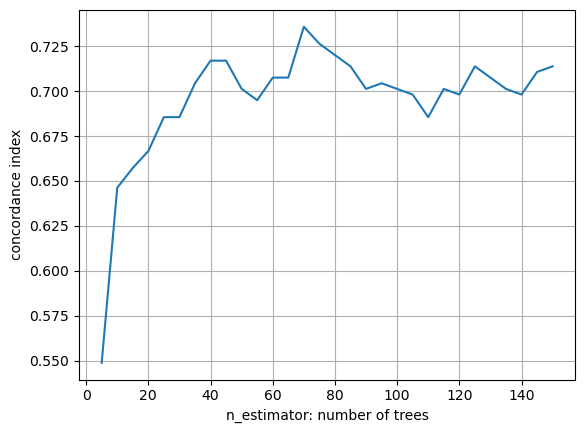

In [124]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)
    
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator: number of trees")
plt.ylabel("concordance index")
plt.grid(True)

**5.2 component-wise least squares base learners.**

The performance increase is much slower here and its maximum performance seems to be below that of the ensemble of tree-based learners. This is not surprising, because with component-wise least squares base learners the overall ensemble is a linear model, whereas with tree-based learners it will be a non-linear model.

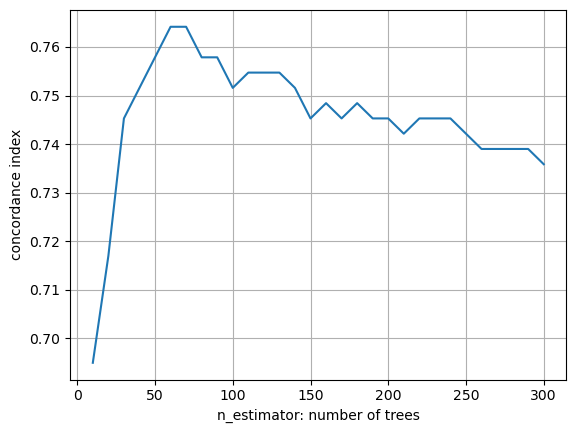

In [126]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)
    
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator: number of trees")
plt.ylabel("concordance index")
plt.grid(True)

In [128]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + X.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 31


Risk Group_2.0   -2.488540
Risk Group_4.0    1.302321
FKBP8            -0.777752
CSGALNACT2        0.704277
RESF1            -0.642029
WWC3             -0.600145
PCNA              0.596825
STT3B             0.440649
MZF1             -0.399339
TUBG2            -0.393628
RPS5             -0.386129
MBOAT1           -0.318855
ENC1              0.310984
CAPRIN1          -0.309238
CHMP4C           -0.304905
SELENOP           0.269563
BAZ1B             0.263295
KHDC4            -0.229082
TTC9              0.220787
AHCY             -0.215085
CHMP6            -0.205600
CREG1             0.171165
HERPUD1          -0.144003
ZFYVE27           0.139316
CACNB3            0.100109
SF3B6             0.082649
UBQLN1            0.074533
EEF2K            -0.069770
PMM2             -0.045492
NEURL1B           0.026118
BMPR2            -0.020259
dtype: float64

**5.3 Accelerated Failure Time Model**

The Accelerated Failure Time (AFT) model is an alternative to Cox’s proportional hazards model. The latter assumes that features only influence the hazard function via a constant multiplicative factor. In contrast, features in an AFT model can accelerate or decelerate the time to an event by a constant factor. The figure below depicts the predicted hazard functions of a proportional hazards model in blue and that of an AFT model in orange.

In [129]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.723


The most important parameter in gradient boosting is the number of base learner to use (n_estimators argument). A higher number will lead to a more complex model. However, this can easily lead to overfitting on the training data. The easiest way would be to just use less base estimators, but there are three alternatives to combat overfitting:

- Use a `learning_rate` less than 1 to restrict the influence of individual base learners, similar to the Ridge penalty.
- Use a non-zero `dropout_rate`, which forces base learners to also account for some of the previously fitted base learners to be missing.
- Use `subsample` less than 1 such that each iteration only a portion of the training data is used. This is also known as stochastic gradient boosting.


In [130]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

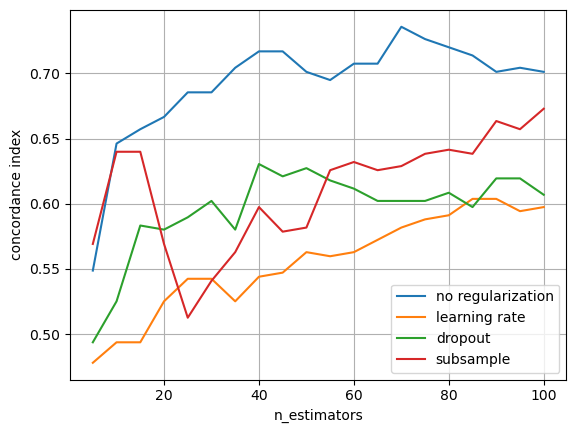

In [131]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [1]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.1, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(10, 10) ## (window_size，max_iter_without_improvement)
est_early_stopping.fit(X_train, y_train, monitor=monitor)
print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

NameError: name 'GradientBoostingSurvivalAnalysis' is not defined

In [168]:
est_es_rs = est_early_stopping.predict(X_test)

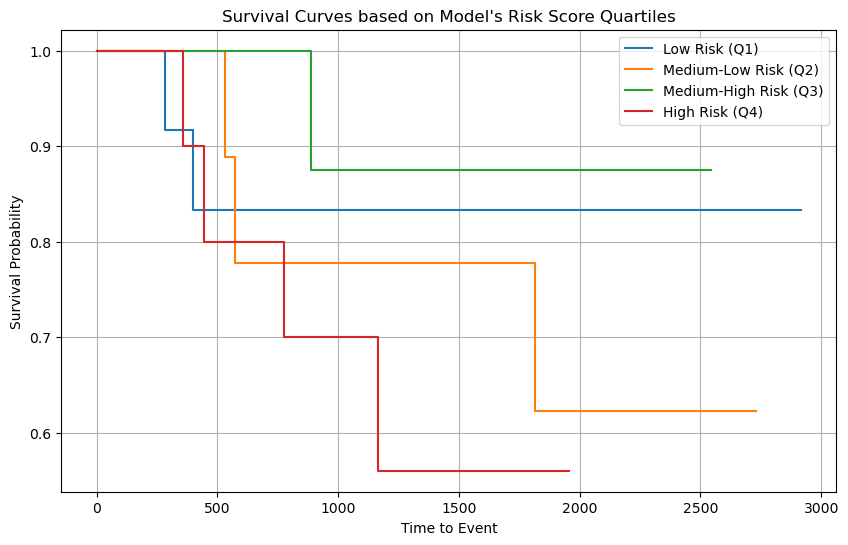

In [170]:
quantile_survival_plot(est_es_rs)

In [ ]:
def quantile_survival_plot(rs_df):
    quantiles = np.quantile(rs_df, [0.25, 0.5, 0.75])

    group_labels = [
        'Low Risk (Q1)', 
        'Medium-Low Risk (Q2)', 
        'Medium-High Risk (Q3)', 
        'High Risk (Q4)'
    ]
    masks = [
        rs_df <= quantiles[0],
        (rs_df > quantiles[0]) & (rs_df <= quantiles[1]),
        (rs_df > quantiles[1]) & (rs_df <= quantiles[2]),
        rs_df > quantiles[2]
    ]

    plt.figure(figsize=(10, 6))
    kmf = KaplanMeierFitter()

    for i, mask in enumerate(masks):
        if np.any(mask):
            time_data = y_test[mask]['time'].flatten()
            event_data = y_test[mask]['event'].flatten()
            
            kmf.fit(time_data, event_data, label=group_labels[i])
            kmf.plot_survival_function(ci_show=False)
        else:
            print(f"Skipping empty group: {group_labels[i]}")

    # 5. Add titles and labels
    plt.title("Survival Curves based on Model's Risk Score Quartiles")
    plt.xlabel("Time to Event")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

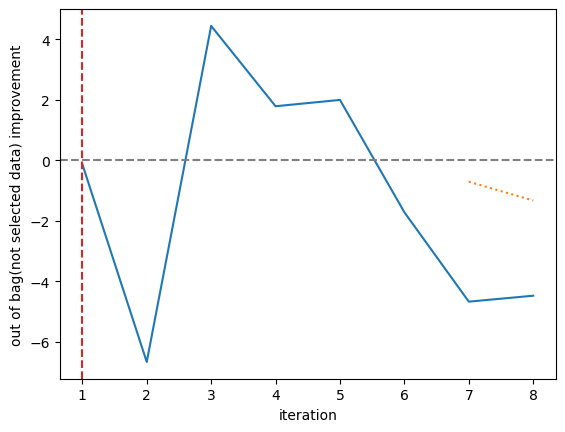

In [190]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_, index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="out of bag(not selected data) improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [122]:
time_points = [365, 365 * 3, 365 * 5]

params = {
    'objective': 'binary:logistic', # For binary classification
    'eval_metric': 'logloss',       # Evaluation metric
    'eta': 0.1,                     # Learning rate
    'max_depth': 3,                 # Maximum tree depth
    'seed': 42,
    'scale_pos_weight': 4           # Handles class imbalance
}

for threshold in time_points:
    print(f"======================================================")
    print(f"      Evaluating XGBoost at {threshold} days ({threshold/365:.0f}-year)")
    print(f"======================================================")

    # 1. Create the Binary Target Variable for Training
    # A patient is a '1' if they had an event before or at the threshold.
    y_train_binary = np.where(
        (y_train['time'] <= threshold) & (y_train['event'] == True), 
        1, 
        0
    )

    # 2. Create the Binary Target Variable for Testing
    # This must be done separately for the test set.
    y_test_binary = np.where(
        (y_test['time'] <= threshold) & (y_test['event'] == True), 
        1, 
        0
    )
    
    # 3. Train and Evaluate the XGBoost Model
    # We set scale_pos_weight to handle class imbalance, which is common in survival data.
    scale_pos_weight = np.sum(y_train_binary == 0) / np.sum(y_train_binary == 1)
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
    xgb_model.fit(X_train, y_train_binary)
    y_pred = xgb_model.predict(X_test)

    # 4. Print the Results
    print(f"Test set accuracy: {accuracy_score(y_test_binary, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_pred))
    print("\n")

      Evaluating XGBoost at 365 days (1-year)
Test set accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.00      0.00      0.00         2

    accuracy                           0.93        45
   macro avg       0.48      0.49      0.48        45
weighted avg       0.91      0.93      0.92        45



      Evaluating XGBoost at 1095 days (3-year)
Test set accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.00      0.00      0.00         8

    accuracy                           0.80        45
   macro avg       0.41      0.49      0.44        45
weighted avg       0.67      0.80      0.73        45



      Evaluating XGBoost at 1825 days (5-year)
Test set accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

   

In [123]:
survival_threshold = 1095 ## set as three years
lifelines_df['Risk_Category'] = np.where(
    (lifelines_df['Time to event if any (days)'] <= survival_threshold) & 
    (lifelines_df['IDFS Event'] == 1), 
    1, 
    0
)
X = lifelines_df.drop(columns=['Time to event if any (days)', 'IDFS Event', 'Risk_Category']) ## 129 - 3 = 126
y = lifelines_df['Risk_Category'] ## 1

NameError: name 'lifelines_df' is not defined

In [ ]:
from sksurv.util import Surv
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic', # 二元分类
    'eval_metric': 'logloss',       # 评估指标
    'eta': 0.1,                     # 学习率
    'max_depth': 3,                 # 树的最大深度
    'seed': 42,
    'scale_pos_weight': 4
}

bst = xgb.train(params, dtrain, num_boost_round=100)

y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int) # 将概率转换为类别

print("--- XGBoost Evaluation Report ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

feature_importances = bst.get_score(importance_type='weight')
print("\nFeature Important (in Weight):")
print(feature_importances)

# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
# xgb_clf.fit(X_scaled, y['IDFS Event'])

# event_probabilities = xgb_clf.predict_proba(X_scaled)[:, 1]

# print(event_probabilities[:5])

--- XGBoost Evaluation Report ---
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.10      0.17      0.12         6

    accuracy                           0.69        45
   macro avg       0.48      0.47      0.47        45
weighted avg       0.76      0.69      0.72        45


Feature Important (in Weight):
{'SERINC1': 2.0, 'WDR6': 1.0, 'PIP5K1A': 1.0, 'TMEM259': 2.0, 'NXF1': 1.0, 'SNX3': 1.0, 'KAT2A': 6.0, 'AHCY': 2.0, 'CSNK1D': 1.0, 'ABHD12': 2.0, 'PARP4': 6.0, 'SLA': 1.0, 'SPPL2B': 15.0, 'NREP': 1.0, 'BCL2L1': 1.0, 'FKBP8': 3.0, 'WWC3': 31.0, 'JADE2': 1.0, 'UBE2J1': 1.0, 'ZNF692': 4.0, 'TRAF1': 1.0, 'CCND1': 1.0, 'SLC25A23': 27.0, 'KLF10': 3.0, 'PCNA': 6.0, 'SRSF1': 2.0, 'SF3B6': 3.0, 'TEP1': 2.0, 'GNAQ': 1.0, 'ITGB1': 9.0, 'MTPN': 1.0, 'ZFYVE27': 4.0, 'RPL10': 1.0, 'CTTN': 8.0, 'ENC1': 20.0, 'PCYOX1': 9.0, 'TTC9': 17.0, 'RPS5': 2.0, 'CSGALNACT2': 7.0, 'NCOA5': 

In [ ]:
print(y_train.value_counts())

Risk_Category
0    84
1    21
Name: count, dtype: int64


Model Evaluation in Same Criterias

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
# Assuming all models (cph, rsf_model, svm_model, xgb_model) are already fitted

time_points = [365, 365 * 3, 365 * 5]

for threshold in time_points:
    print(f"======================================================")
    print(f"      Comparing Models at {threshold} days ({threshold/365:.0f}-year)")
    print(f"======================================================")
    
    # Define the ground truth for this time point
    y_true_binary = np.where(
        (y_test['time'] <= threshold) & (y_test['event'] == True), 
        1, 
        0
    )

    # --- 1. Get Predictions from SVM ---
    svm_pred = svm_model.predict(X_test)
    print("\n--- SVM Classification Report ---")
    print(classification_report(y_true_binary, svm_pred, zero_division=0))

    # --- 2. Get Predictions from XGBoost ---
    xgb_pred = xgb_model.predict(X_test)
    print("\n--- XGBoost Classification Report ---")
    print(classification_report(y_true_binary, xgb_pred, zero_division=0))

    # --- 3. Get Predictions from Random Survival Forest ---
    surv_funcs = rsf_model.predict_survival_function(X_test)
    rsf_probs = np.array([f(threshold) for f in surv_funcs])
    rsf_pred = np.where(rsf_probs < 0.5, 1, 0) # Convert survival prob to binary class
    print("\n--- RSF as a Classifier Report ---")
    print(classification_report(y_true_binary, rsf_pred, zero_division=0))

    # --- 4. Get Predictions from CoxPH ---
    surv_probs_cph = cph.predict_survival_function(X_test, times=[threshold]).iloc[0]
    cph_pred = np.where(surv_probs_cph < 0.5, 1, 0)
    print("\n--- CoxPH as a Classifier Report ---")
    print(classification_report(y_true_binary, cph_pred, zero_division=0))
    
    print("\n")

      Comparing Models at 365 days (1-year)

--- SVM Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.79      0.87        43
           1       0.10      0.50      0.17         2

    accuracy                           0.78        45
   macro avg       0.54      0.65      0.52        45
weighted avg       0.93      0.78      0.84        45


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.20      0.50      0.29         2

    accuracy                           0.89        45
   macro avg       0.59      0.70      0.61        45
weighted avg       0.94      0.89      0.91        45


--- RSF as a Classifier Report ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       0.00      0.00      0.00         2

    accuracy                